In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import numpy as np
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [160]:
data = pd.read_csv('./data/IBOV.csv')

# Análise da Correlação dos dados

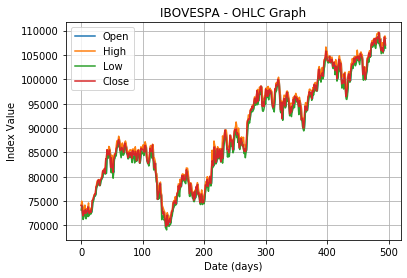

In [9]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(data['Date'])), data['Open'].values, label='Open')
ax.plot(np.arange(len(data['Date'])), data['High'].values, label='High')
ax.plot(np.arange(len(data['Date'])), data['Low'].values, label='Low')
ax.plot(np.arange(len(data['Date'])), data['Close'].values, label='Close')
ax.set(xlabel='Date (days)', ylabel='Index Value',
       title='IBOVESPA - OHLC Graph')
ax.legend()
ax.grid()

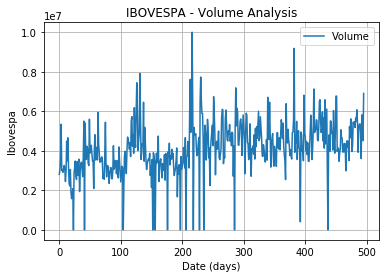

In [10]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(data['Date'])), data['Volume'].values, label='Volume')
ax.set(xlabel='Date (days)', ylabel='Ibovespa',
       title='IBOVESPA - Volume Analysis')
ax.legend()
ax.grid()

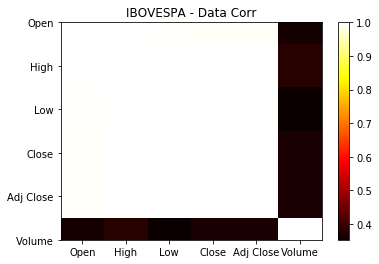

In [11]:
corr = data.corr()  
plt.imshow(corr, cmap='hot', interpolation='none')  
plt.colorbar()  
plt.xticks(range(len(corr)), corr.columns)  
plt.yticks(range(len(corr)), corr.columns)
plt.title('IBOVESPA - Data Corr')
plt.savefig("correl.png")  
plt.show()

# Processamento dos Dados (ARIMA - IBOVESPA [Close])

In [206]:
df = pd.read_csv('./data/IBOV.csv', header=0, index_col=0)
df = df['Close']
data = pd.Series(df.values,
                index = pd.DatetimeIndex(
                    data = (tuple(pd.date_range('27/11/2017',
                                                periods = 496,
                                                freq = 'B'))),
                    freq = 'B'
                ))

## Teste para validar se a função é estacionária
##### p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
##### p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

### Para d= 0

Results of Dickey-Fuller Test:
Test Statistic                  -0.981747
p-value                          0.759863
Number of Lags                   2.000000
Number of Observations Used    493.000000
dtype: float64


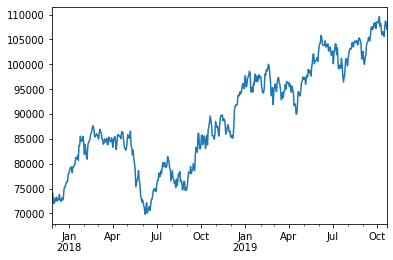

In [13]:
import pandas as pd
print("Results of Dickey-Fuller Test:")
df_test = adfuller(data, autolag = "AIC")
df_output = pd.Series(df_test[0:4],
                     index = ["Test Statistic", "p-value", "Number of Lags",
                             "Number of Observations Used"])
print(df_output)
data.plot()

### Para d= 1

Results of Dickey-Fuller Test:
Test Statistic                -1.736166e+01
p-value                        5.199467e-30
Number of Lags                 1.000000e+00
Number of Observations Used    4.930000e+02
dtype: float64


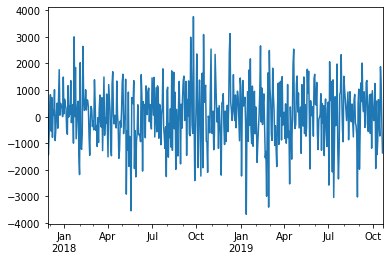

In [14]:
import pandas as pd
data_diff1 = data.diff().dropna()
print("Results of Dickey-Fuller Test:")
df_test = adfuller(data_diff1, autolag = "AIC")
df_output = pd.Series(df_test[0:4],
                     index = ["Test Statistic", "p-value", "Number of Lags",
                             "Number of Observations Used"])
print(df_output)
data_diff1.plot()

In [15]:
data_diff1.describe()

count     495.000000
mean       66.666667
std      1124.751595
min     -3675.000000
25%      -633.000000
50%        80.000000
75%       804.000000
max      3762.000000
dtype: float64

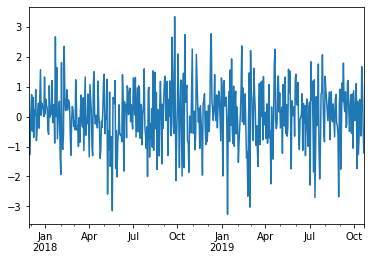

In [16]:
desv_pad_diff1 = (data_diff1/data_diff1.describe()['std'])
desv_pad_diff1.plot()

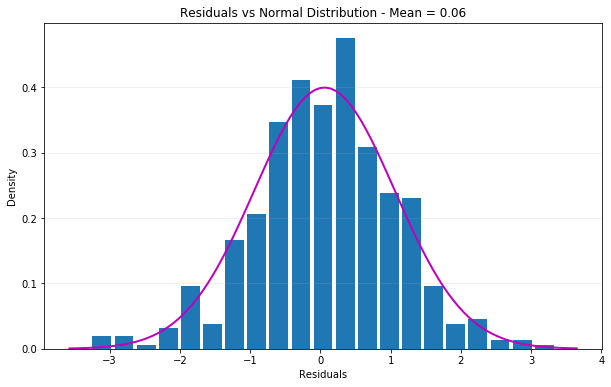

In [17]:
import matplotlib.pyplot as plt
from numpy import linspace
from scipy.stats import norm

plt.figure(figsize=(10,6))
plt.hist(desv_pad_diff1, bins='auto', density=True, rwidth=0.85, label='residuals')
mean_resid, std_resid = norm.fit(desv_pad_diff1)
xmin, xmax = plt.xlim()
curve_length = linspace(xmin, xmax, 100)
bell_curve = norm.pdf(curve_length, mean_resid, std_resid)
plt.plot(curve_length, bell_curve, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals vs Normal Distribution - Mean = '+str(round(mean_resid, 2)))
plt.show()

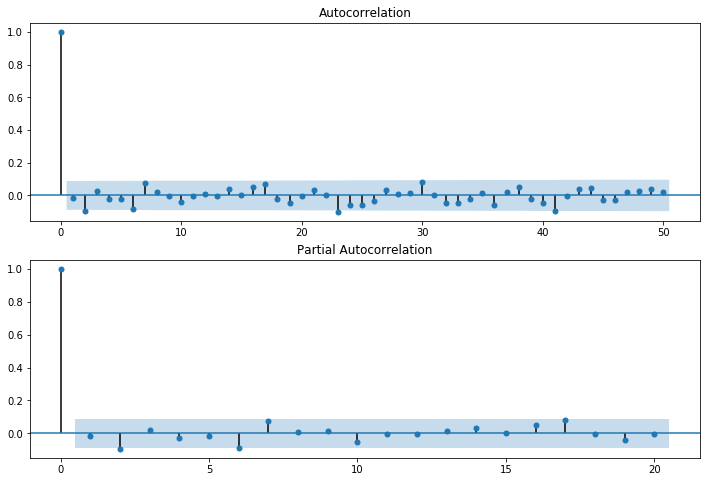

In [18]:
# Autocorrelation (MA - q)
# Partial Autocorrelation (AR - p)
#TODO: Perguntar se deve ser feito os calculos com o diff1
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data_diff1, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data_diff1, lags=20, ax=ax2)

### LOG DIFF 1

Results of Dickey-Fuller Test:
Test Statistic                -1.735318e+01
p-value                        5.256491e-30
Number of Lags                 1.000000e+00
Number of Observations Used    4.930000e+02
dtype: float64


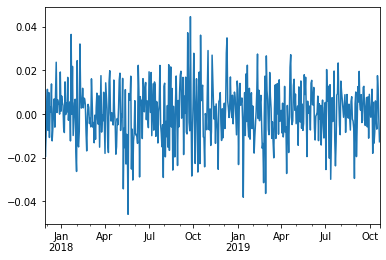

In [19]:
data_log = pd.Series(np.log(data.values),
                index = pd.DatetimeIndex(
                    data = (tuple(pd.date_range('27/11/2017',
                                                periods = 496,
                                                freq = 'B'))),
                    freq = 'B'
                ))

data_log_diff1 = data_log.diff().dropna()

print("Results of Dickey-Fuller Test:")
df_test = adfuller(data_log_diff1.values, autolag = "AIC")
df_output = pd.Series(df_test[0:4],
                     index = ["Test Statistic", "p-value", "Number of Lags",
                             "Number of Observations Used"])
print(df_output)

data_log_diff1.plot()

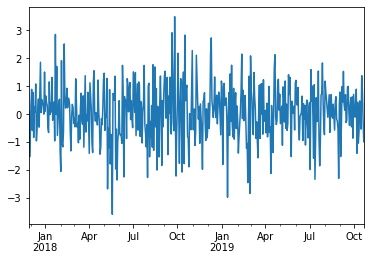

In [20]:
desv_pad = (data_log_diff1/data_log_diff1.describe()['std'])
desv_pad.plot()

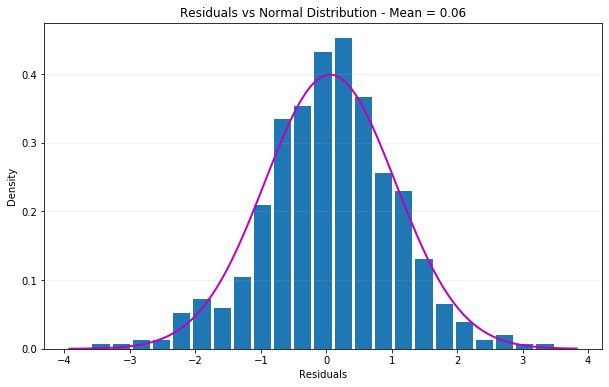

In [21]:
import matplotlib.pyplot as plt
from numpy import linspace
from scipy.stats import norm

plt.figure(figsize=(10,6))
plt.hist(desv_pad, bins='auto', density=True, rwidth=0.85, label='residuals')
mean_resid, std_resid = norm.fit(desv_pad)
xmin, xmax = plt.xlim()
curve_length = linspace(xmin, xmax, 100)
bell_curve = norm.pdf(curve_length, mean_resid, std_resid)
plt.plot(curve_length, bell_curve, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals vs Normal Distribution - Mean = '+str(round(mean_resid, 2)))
plt.show()

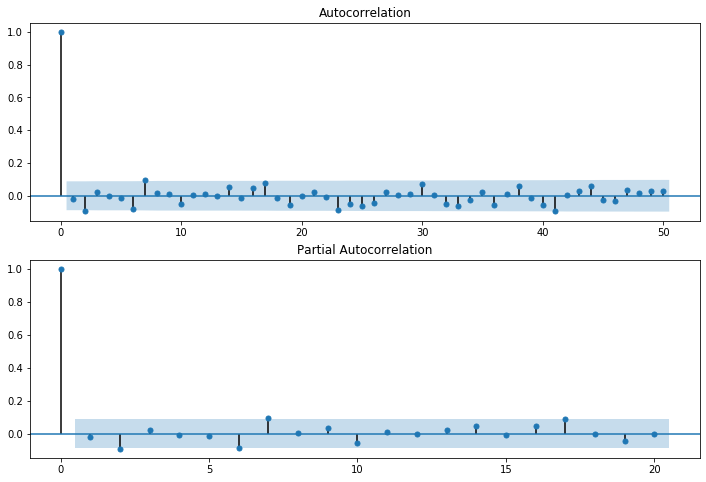

In [22]:
# Autocorrelation (MA - q)
# Partial Autocorrelation (AR - p)
#TODO: Perguntar se deve ser feito os calculos com o diff1
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data_log_diff1, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data_log_diff1, lags=20, ax=ax2)

##### Analisando o gráfico de Autocorrelation temos q=0 e p=0

### Validação do ARIMA para (0,1,0) - Método Analítico

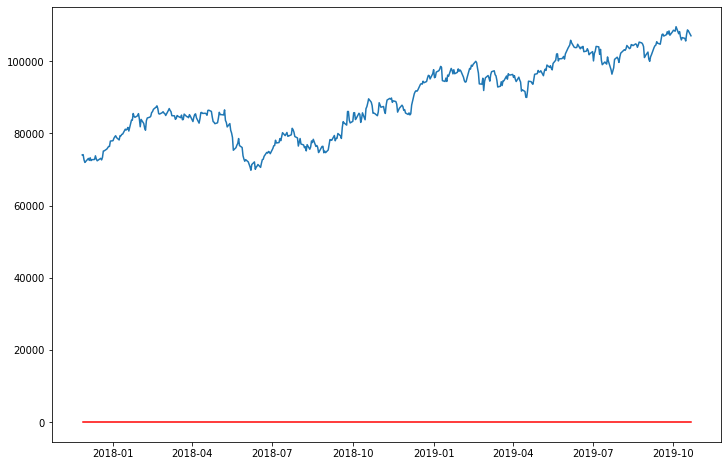

In [50]:
# ARIMA model setup
# --> Considerações do residuo do ARIMA
# --> Mean (meadia)
# --> Autocorrelation (Autocorrelação)
# --> Normal distribution (Distribuição Normal)
model = ARIMA(data, order=(0, 1, 0))
results_ar1 = model.fit()
plt.figure(figsize=(12,8))
plt.plot(data)
plt.plot(results_ar1.fittedvalues, color='red')

ARIMA [Mean]:  -1.6995608063433506e-14


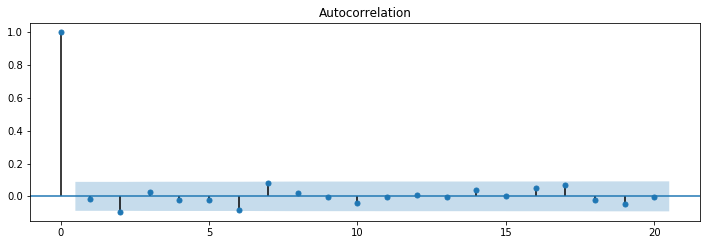

In [51]:
# Mean
print('ARIMA [Mean]: ', np.mean(results_ar1.resid))

# ACF plot to test for autorrelation
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results_ar1.resid, lags=20, ax=ax1)

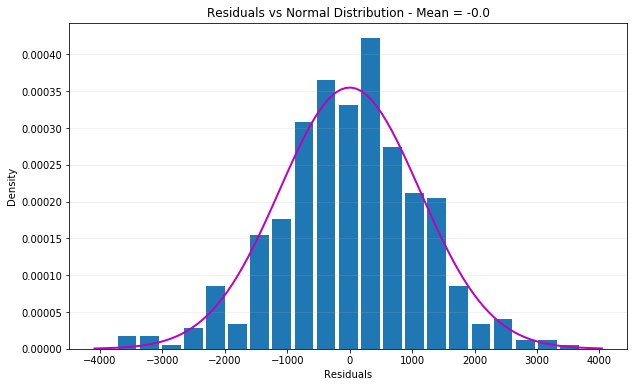

In [52]:
import matplotlib.pyplot as plt
from numpy import linspace
from scipy.stats import norm

plt.figure(figsize=(10,6))
plt.hist(results_ar1.resid, bins='auto', density=True, rwidth=0.85, label='residuals')
mean_resid, std_resid = norm.fit(results_ar1.resid)
xmin, xmax = plt.xlim()
curve_length = linspace(xmin, xmax, 100)
bell_curve = norm.pdf(curve_length, mean_resid, std_resid)
plt.plot(curve_length, bell_curve, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals vs Normal Distribution - Mean = '+str(round(mean_resid, 2)))
plt.show()

In [53]:
#Informações relevantes são:
#    AIC (Akaike): (Estudar)
#    BIC: Base info criterion (Estudar)
results_ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  495
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4179.406
Method:                           css   S.D. of innovations           1123.615
Date:                Fri, 06 Dec 2019   AIC                           8362.812
Time:                        15:16:14   BIC                           8371.222
Sample:                    11-28-2017   HQIC                          8366.114
                         - 10-21-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.6667     50.503      1.320      0.187     -32.317     165.650
==============================================================================
"""

### ARIMA Iterativo - Método Computacional (Sem considerar sazonalidade)

In [83]:
arima_model = pm.auto_arima(data, error_action='ignore', suppress_warnings=True,
                    seasonal=False, start_q=0, start_p=0,
                    max_order=50, max_d=3, stepwise=False, trace=True)

Fit ARIMA: order=(0, 1, 0); AIC=8362.812, BIC=8371.222, Fit time=0.004 seconds
Fit ARIMA: order=(0, 1, 1); AIC=8364.624, BIC=8377.238, Fit time=0.023 seconds
Fit ARIMA: order=(0, 1, 2); AIC=8361.977, BIC=8378.795, Fit time=0.062 seconds
Fit ARIMA: order=(0, 1, 3); AIC=8363.672, BIC=8384.695, Fit time=0.167 seconds
Fit ARIMA: order=(0, 1, 4); AIC=8364.858, BIC=8390.085, Fit time=0.183 seconds
Fit ARIMA: order=(0, 1, 5); AIC=8366.827, BIC=8396.259, Fit time=0.357 seconds
Fit ARIMA: order=(1, 1, 0); AIC=8364.660, BIC=8377.273, Fit time=0.014 seconds
Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 0); AIC=8362.205, BIC=8379.023, Fit time=0.098 seconds
Fit ARIMA: order=(2, 1, 1); AIC=8

In [84]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  495
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -4170.484
Method:                       css-mle   S.D. of innovations           1102.921
Date:                Fri, 06 Dec 2019   AIC                           8360.969
Time:                        15:28:34   BIC                           8403.014
Sample:                             1   HQIC                          8377.474
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.1142     42.677      1.573      0.116     -16.532     150.760
ar.L1.D.y      0.1911      0.250      0.763      0.446      -0.300       0.682
ar.L2.D.y     -0.3800      0.186     -2.043      0.042      -0.745      -0.015
ar.L3.D.y     -0.2273      0.206     -1.104      0.270      -0.631       0.176
ar.L4.D.y      0.5132      0.213      2.407      0.016       0.095       0.931
ma.L1.D.y     -0.2152      0.235     -0.914      0.361      -0.677       0.246
ma.L2.D.y      0.2943      0.169      1.745      0.082      -0.036       0.625
ma.L3.D.y      0.3067      0.183      1.680      0.094      -0.051       0.665
ma.L4.D.y     -0.6093      0.203     -2.994      0.003      -1.008      -0.211
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2830           -0.0000j            1.2830           -0.5000
AR.2            0.1450           -1.0181j            1.0284           -0.2275
AR.3            0.1450           +1.0181j            1.0284            0.2275
AR.4            1.4361           -0.0000j            1.4361           -0.0000
MA.1           -1.1750           -0.0000j            1.1750           -0.5000
MA.2            0.1674           -1.0057j            1.0195           -0.2238
MA.3            0.1674           +1.0057j            1.0195            0.2238
MA.4            1.3437           -0.0000j            1.3437           -0.0000
-----------------------------------------------------------------------------
"""

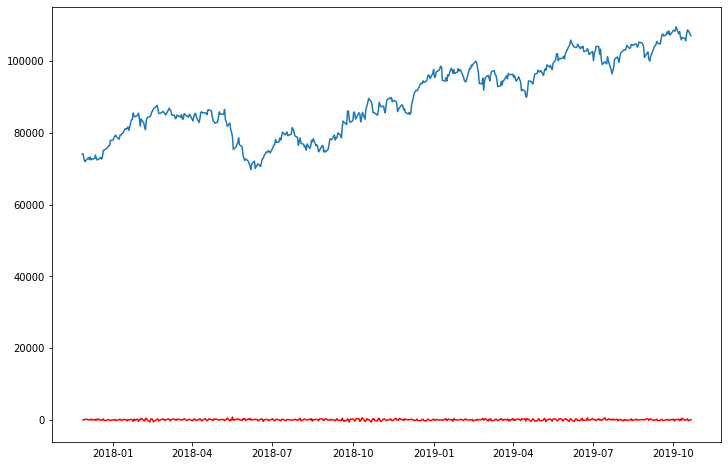

In [23]:
# ARIMA model setup
# --> Considerações do residuo do ARIMA
# --> Mean (meadia)
# --> Autocorrelation (Autocorrelação)
# --> Normal distribution (Distribuição Normal)
model = ARIMA(data, order=(4, 1, 4))
results_ar1 = model.fit()
plt.figure(figsize=(12,8))
plt.plot(data)
plt.plot(results_ar1.fittedvalues, color='red')

ARIMA [Mean]:  -0.24113477603374958


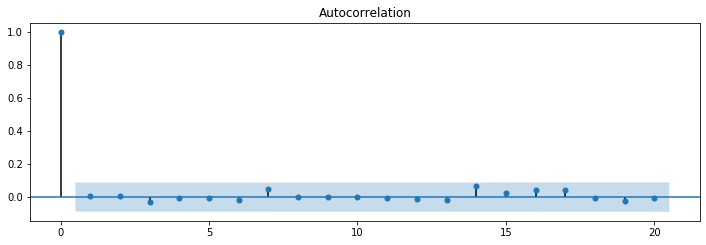

In [24]:
# Mean
print('ARIMA [Mean]: ', np.mean(results_ar1.resid))

# ACF plot to test for autorrelation
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results_ar1.resid, lags=20, ax=ax1)

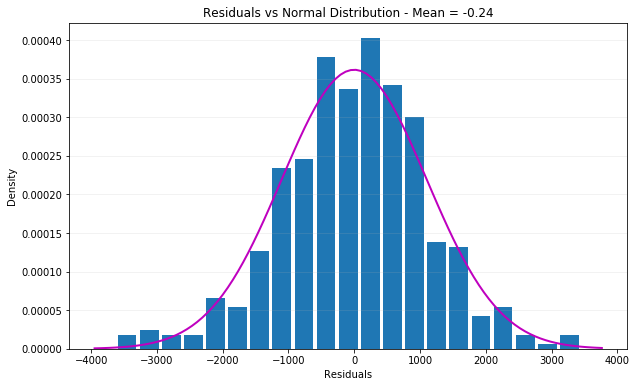

In [25]:
import matplotlib.pyplot as plt
from numpy import linspace
from scipy.stats import norm

plt.figure(figsize=(10,6))
plt.hist(results_ar1.resid, bins='auto', density=True, rwidth=0.85, label='residuals')
mean_resid, std_resid = norm.fit(results_ar1.resid)
xmin, xmax = plt.xlim()
curve_length = linspace(xmin, xmax, 100)
bell_curve = norm.pdf(curve_length, mean_resid, std_resid)
plt.plot(curve_length, bell_curve, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals vs Normal Distribution - Mean = '+str(round(mean_resid, 2)))
plt.show()

In [26]:
forecast = results_ar1.predict(typ='levels')
actual = data[1:]

mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
me = np.mean(forecast - actual)                           # ME
mae = np.mean(np.abs(forecast - actual))                  # MAE
mpe = np.mean((forecast - actual)/actual)                 # MPE
rmse = np.mean((forecast - actual)**2)**.5                # RMSE
print('mape: %s' % mape)
print('me: %s' % me)
print('mae: %s' % mae)
print('mpe: %s' % mpe)
print('rmse: %s' % rmse)

mape: 0.009734822165845963
me: 0.2411347760333541
mae: 858.9918713518446
mpe: 0.00010688570412045886
rmse: 1103.2929953737573


In [53]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
forecasting = 2
lag = 50
new_data = data[:-lag]
train = new_data[:len(data)-forecasting]
test = new_data[-forecasting:]

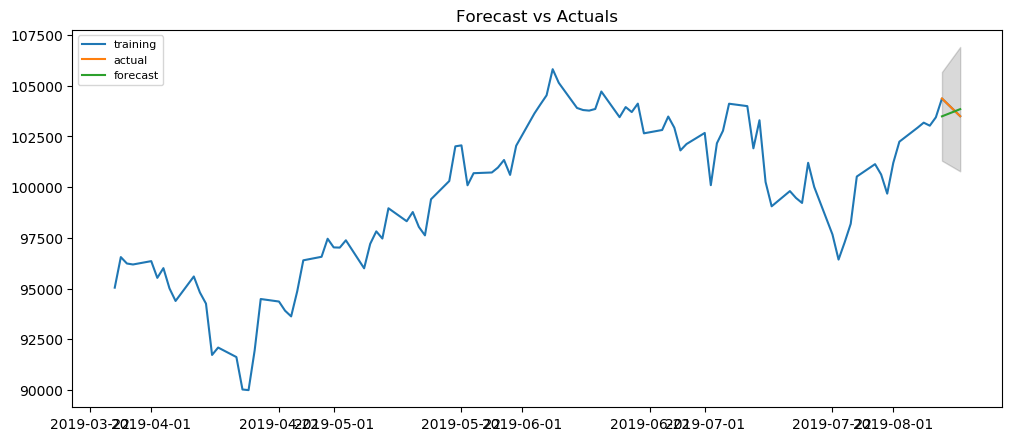

In [54]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(4, 1, 4))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(forecasting, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[-100:], label='training')
plt.plot(test[-100:], label='actual')
plt.plot(fc_series[-100:], label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [94]:
## Treinamento do Residuo utilizando SVM

In [87]:
df_residuo = pd.DataFrame({
    'res_1': results_ar1.resid.shift(4),
    'res_2': results_ar1.resid.shift(3),
    'res_3': results_ar1.resid.shift(2),
    'res_4': results_ar1.resid.shift(1),
    'target': results_ar1.resid.shift(0)
}).dropna()

In [88]:
df_data = pd.DataFrame({
    'res_1': data.shift(3),
    'res_2': data.shift(2),
    'res_3': data.shift(1),
    'res_4': data.shift(0),
    'target': results_ar1.resid.shift(4)
}).dropna()

In [89]:
data_diff = data.diff()
df_diff = pd.DataFrame({
    'res_1': data_diff.shift(3),
    'res_2': data_diff.shift(2),
    'res_3': data_diff.shift(1),
    'res_4': data_diff.shift(0),
    'target': results_ar1.resid.shift(4)
}).dropna()

In [245]:
df_all = pd.DataFrame({
    'data-3': data.shift(3),
    'data-2': data.shift(2),
    'data-1': data.shift(1),
    'data-0': data.shift(0),
    'data_diff-3': data_diff.shift(3),
    'data_diff-2': data_diff.shift(2),
    'data_diff-1': data_diff.shift(1),
    'data_diff-0': data_diff.shift(0),
    'res-4': results_ar1.resid.shift(4),
    'res-3': results_ar1.resid.shift(3),
    'res-2': results_ar1.resid.shift(2),
    'res-1': results_ar1.resid.shift(1),
    'res_diff-4': results_ar1.resid.diff().shift(4),
    'res_diff-3': results_ar1.resid.diff().shift(3),
    'res_diff-2': results_ar1.resid.diff().shift(2),
    'res_diff-1': results_ar1.resid.diff().shift(1),
    'target': results_ar1.resid.shift(0)
}).dropna()

In [246]:
df_all

,data-3,data-2,data-1,data-0,data_diff-3,data_diff-2,data_diff-1,data_diff-0,res-4,res-3,res-2,res-1,res_diff-4,res_diff-3,res_diff-2,res_diff-1,target
2017-12-05,71971.0,72264.0,73090.0,72546.0,-729.0,293.0,826.0,-544.0,-1506.729787,-840.685045,53.302137,762.760380,-1520.615622,666.044742,893.987182,709.458243,-566.339510
2017-12-06,72264.0,73090.0,72546.0,73268.0,293.0,826.0,-544.0,722.0,-840.685045,53.302137,762.760380,-566.339510,666.044742,893.987182,709.458243,-1329.099890,668.921882
2017-12-07,73090.0,72546.0,73268.0,72487.0,826.0,-544.0,722.0,-781.0,53.302137,762.760380,-566.339510,668.921882,893.987182,709.458243,-1329.099890,1235.261392,-1044.585130
2017-12-08,72546.0,73268.0,72487.0,72732.0,-544.0,722.0,-781.0,245.0,762.760380,-566.339510,668.921882,-1044.585130,709.458243,-1329.099890,1235.261392,-1713.507012,273.863958
2017-12-11,73268.0,72487.0,72732.0,72800.0,722.0,-781.0,245.0,68.0,-566.339510,668.921882,-1044.585130,273.863958,-1329.099890,1235.261392,-1713.507012,1318.449088,-80.329389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-15,105914.0,106557.0,106347.0,105618.0,-871.0,643.0,-210.0,-729.0,-1712.787328,-756.853790,137.503294,-101.786053,-2485.370044,955.933539,894.357084,-239.289347,-843.161917
2019-10-16,106557.0,106347.0,105618.0,107497.0,643.0,-210.0,-729.0,1879.0,-756.853790,137.503294,-101.786053,-843.161917,955.933539,894.357084,-239.289347,-741.375864,1816.166400
2019-10-17,106347.0,105618.0,107497.0,108692.0,-210.0,-729.0,1879.0,1195.0,137.503294,-101.786053,-843.161917,1816.166400,894.357084,-239.289347,-741.375864,2659.328317,874.596950
2019-10-18,105618.0,107497.0,108692.0,108424.0,-729.0,1879.0,1195.0,-268.0,-101.786053,-843.161917,1816.166400,874.596950,-239.289347,-741.375864,2659.328317,-941.569450,-50.470371


In [352]:
len(results_ar1.resid.diff().shift(-4).dropna().values)

491

In [354]:
len(results_ar1.resid.shift(-2).dropna().values[:-2])

491

In [355]:
data_resid = results_ar1.resid
df_all_2 = pd.DataFrame({
    'data-29': data.shift(-2).dropna().values[:-3],
    'data-30': data.shift(-3).dropna().values[:-2],
    'data-1': data.shift(-4).dropna().values[:-1],
    'data-4': data.shift(-5).dropna().values,
    'data_diff-29': data.diff().shift(-2).dropna().values[:-3],
    'data_diff-30': data.diff().shift(-3).dropna().values[:-2],
    'data_diff-1': data.diff().shift(-4).dropna().values[:-1],
    'data_diff-4': data.diff().shift(-5).dropna().values,
    'res-29': results_ar1.resid.shift(-1).dropna().values[:-3],
    'res-30': results_ar1.resid.shift(-2).dropna().values[:-2],
    'res-1': results_ar1.resid.shift(-3).dropna().values[:-1],
    'res-4': results_ar1.resid.shift(-4).dropna().values,
    'res_diff-29': results_ar1.resid.diff().shift(-1).dropna().values[:-3],
    'res_diff-30': results_ar1.resid.diff().shift(-2).dropna().values[:-2],
    'res_diff-1': results_ar1.resid.diff().shift(-3).dropna().values[:-1],
    'res_diff-4': results_ar1.resid.diff().shift(-4).dropna().values,
    'target': results_ar1.resid.shift(-2).dropna().values[:-2]
})

In [357]:
df = df_all_2

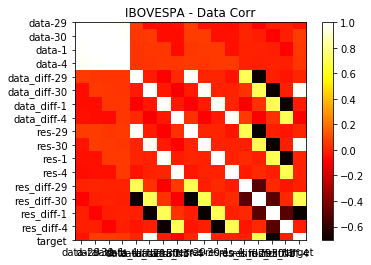

In [358]:
corr = df.corr()  
plt.imshow(corr, cmap='hot', interpolation='none')  
plt.colorbar()  
plt.xticks(range(len(corr)), corr.columns)  
plt.yticks(range(len(corr)), corr.columns)
plt.title('IBOVESPA - Data Corr')
plt.savefig("correl.png")  
plt.show()

Epoch 1/100
368/368 [==============================] - 0s 337us/step - loss: 10944625.6196
Epoch 2/100
368/368 [==============================] - 0s 33us/step - loss: 5260501.0163
Epoch 3/100
368/368 [==============================] - 0s 24us/step - loss: 2611982.0870
Epoch 4/100
368/368 [==============================] - 0s 24us/step - loss: 1500833.0557
Epoch 5/100
368/368 [==============================] - 0s 41us/step - loss: 1162350.3533
Epoch 6/100
368/368 [==============================] - 0s 22us/step - loss: 1227758.9212
Epoch 7/100
368/368 [==============================] - 0s 24us/step - loss: 1333916.3784
Epoch 8/100
368/368 [==============================] - 0s 38us/step - loss: 1302895.7120
Epoch 9/100
368/368 [==============================] - 0s 19us/step - loss: 1203527.1943
Epoch 10/100
368/368 [==============================] - 0s 41us/step - loss: 1094824.4803
Epoch 11/100
368/368 [==============================] - 0s 22us/step - loss: 1046314.1739
Epoch 12/100
368/

368/368 [==============================] - 0s 24us/step - loss: 4369.3317
Epoch 94/100
368/368 [==============================] - 0s 22us/step - loss: 4126.6468
Epoch 95/100
368/368 [==============================] - 0s 33us/step - loss: 3927.2363
Epoch 96/100
368/368 [==============================] - ETA: 0s - loss: 3463.03 - 0s 27us/step - loss: 3711.5479
Epoch 97/100
368/368 [==============================] - 0s 38us/step - loss: 3643.2075
Epoch 98/100
368/368 [==============================] - 0s 27us/step - loss: 3549.9432
Epoch 99/100
368/368 [==============================] - 0s 22us/step - loss: 3353.1297
Epoch 100/100
368/368 [==============================] - 0s 38us/step - loss: 3311.7988


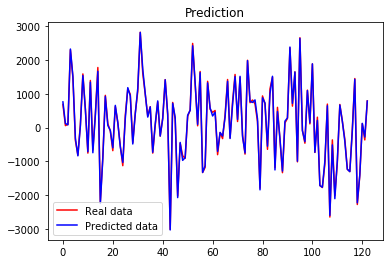

In [406]:
# Importing the dataset
X = df.drop(columns=['target']).values
y = df.target.values
# X = df.drop(columns=['Close','Date']).values[:-1]
# y = df['Close'].shift(-1).dropna().values

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Initialising the ANN
model = Sequential()
model.add(Dense(12, input_dim=16, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the ANN to the Training set
history = model.fit(X_train, y_train, batch_size = 100, epochs = 100)

y_pred = model.predict(X_test)

plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

dict_keys(['loss'])


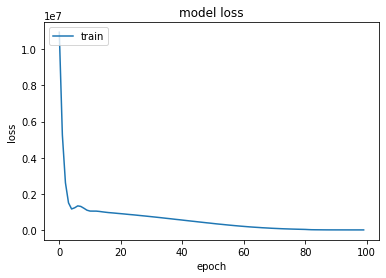

In [407]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

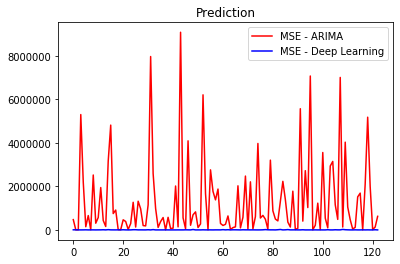

In [408]:
y_pred = model.predict(X_test)
mse_arima = y_test**2
error_deep = (y_test - np.hstack(y_pred))
mse_deep = (y_test - np.hstack(y_pred))**2
plt.plot(mse_arima, color = 'red', label = 'MSE - ARIMA')
plt.plot(mse_deep, color = 'blue', label = 'MSE - Deep Learning')
plt.title('Prediction')
plt.legend()
plt.show()

In [409]:
df_error = pd.DataFrame.from_dict({
    'arima': mse_arima,
    'dp': mse_deep
})
df_error.describe()

,arima,dp
count,1.230000e+02,123.000000
mean,1.315350e+06,3174.328344
std,1.798016e+06,4314.201510
min,2.245800e+03,0.246295
25%,1.324698e+05,353.688860
50%,5.688559e+05,1506.301428
75%,1.827583e+06,3979.974706
max,9.076918e+06,22038.739455


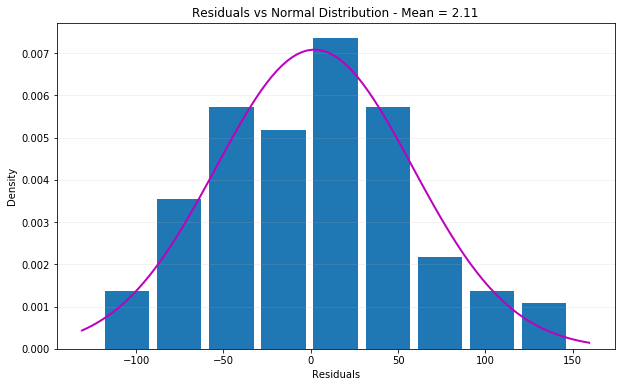

In [410]:
plt.figure(figsize=(10,6))
plt.hist(error_deep, bins='auto', density=True, rwidth=0.85, label='residuals')
mean_resid, std_resid = norm.fit(error_deep)
xmin, xmax = plt.xlim()
curve_length = linspace(xmin, xmax, 100)
bell_curve = norm.pdf(curve_length, mean_resid, std_resid)
plt.plot(curve_length, bell_curve, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals vs Normal Distribution - Mean = '+str(round(mean_resid, 2)))
plt.show()

Epoch 1/1000
367/367 [==============================] - 0s 343us/step - loss: 2466139.9268
Epoch 2/1000
367/367 [==============================] - 0s 22us/step - loss: 1436421.5078
Epoch 3/1000
367/367 [==============================] - 0s 38us/step - loss: 1282322.0184
Epoch 4/1000
367/367 [==============================] - 0s 41us/step - loss: 1349221.4418
Epoch 5/1000
367/367 [==============================] - 0s 22us/step - loss: 1376252.9196
Epoch 6/1000
367/367 [==============================] - 0s 35us/step - loss: 1327115.2830
Epoch 7/1000
367/367 [==============================] - 0s 19us/step - loss: 1282622.7646
Epoch 8/1000
367/367 [==============================] - 0s 46us/step - loss: 1271098.4527
Epoch 9/1000
367/367 [==============================] - 0s 27us/step - loss: 1275797.7107
Epoch 10/1000
367/367 [==============================] - 0s 41us/step - loss: 1275005.2500
Epoch 11/1000
367/367 [==============================] - 0s 27us/step - loss: 1266807.9584
Epoch 1

367/367 [==============================] - 0s 30us/step - loss: 900793.0920
Epoch 92/1000
367/367 [==============================] - 0s 27us/step - loss: 891393.6465
Epoch 93/1000
367/367 [==============================] - 0s 27us/step - loss: 889175.4336
Epoch 94/1000
367/367 [==============================] - 0s 35us/step - loss: 875876.4206
Epoch 95/1000
367/367 [==============================] - 0s 30us/step - loss: 865132.5967
Epoch 96/1000
367/367 [==============================] - 0s 30us/step - loss: 852962.4467
Epoch 97/1000
367/367 [==============================] - 0s 33us/step - loss: 836883.9900
Epoch 98/1000
367/367 [==============================] - 0s 49us/step - loss: 825853.8631
Epoch 99/1000
367/367 [==============================] - 0s 33us/step - loss: 814983.7541
Epoch 100/1000
367/367 [==============================] - 0s 41us/step - loss: 804599.7827
Epoch 101/1000
367/367 [==============================] - 0s 38us/step - loss: 788192.9067
Epoch 102/1000
367/367

367/367 [==============================] - 0s 30us/step - loss: 18968.8846
Epoch 182/1000
367/367 [==============================] - 0s 33us/step - loss: 18646.5970
Epoch 183/1000
367/367 [==============================] - 0s 30us/step - loss: 18626.9664
Epoch 184/1000
367/367 [==============================] - 0s 27us/step - loss: 20430.2461
Epoch 185/1000
367/367 [==============================] - 0s 30us/step - loss: 19293.6492
Epoch 186/1000
367/367 [==============================] - 0s 27us/step - loss: 18752.8140
Epoch 187/1000
367/367 [==============================] - 0s 27us/step - loss: 18722.8334
Epoch 188/1000
367/367 [==============================] - 0s 33us/step - loss: 19625.8349
Epoch 189/1000
367/367 [==============================] - 0s 117us/step - loss: 18598.4053
Epoch 190/1000
367/367 [==============================] - 0s 30us/step - loss: 18376.6825
Epoch 191/1000
367/367 [==============================] - 0s 30us/step - loss: 19131.7892
Epoch 192/1000
367/367 [

367/367 [==============================] - 0s 38us/step - loss: 12674.9436
Epoch 273/1000
367/367 [==============================] - 0s 30us/step - loss: 12612.2797
Epoch 274/1000
367/367 [==============================] - 0s 38us/step - loss: 12639.8317
Epoch 275/1000
367/367 [==============================] - 0s 25us/step - loss: 12752.3638
Epoch 276/1000
367/367 [==============================] - 0s 30us/step - loss: 13410.7000
Epoch 277/1000
367/367 [==============================] - 0s 35us/step - loss: 12893.4645
Epoch 278/1000
367/367 [==============================] - 0s 33us/step - loss: 13241.2104
Epoch 279/1000
367/367 [==============================] - 0s 25us/step - loss: 13653.3701
Epoch 280/1000
367/367 [==============================] - 0s 30us/step - loss: 13390.4487
Epoch 281/1000
367/367 [==============================] - 0s 25us/step - loss: 12930.0865
Epoch 282/1000
367/367 [==============================] - 0s 30us/step - loss: 13059.2486
Epoch 283/1000
367/367 [=

Epoch 363/1000
367/367 [==============================] - 0s 33us/step - loss: 9743.4866
Epoch 364/1000
367/367 [==============================] - 0s 25us/step - loss: 10622.0953
Epoch 365/1000
367/367 [==============================] - ETA: 0s - loss: 9700.88 - 0s 30us/step - loss: 9855.4949
Epoch 366/1000
367/367 [==============================] - 0s 30us/step - loss: 10315.1942
Epoch 367/1000
367/367 [==============================] - 0s 25us/step - loss: 9792.8452
Epoch 368/1000
367/367 [==============================] - 0s 35us/step - loss: 10145.3141
Epoch 369/1000
367/367 [==============================] - 0s 38us/step - loss: 9568.3111
Epoch 370/1000
367/367 [==============================] - 0s 25us/step - loss: 9803.8367
Epoch 371/1000
367/367 [==============================] - 0s 30us/step - loss: 9654.0338
Epoch 372/1000
367/367 [==============================] - 0s 30us/step - loss: 10862.1935
Epoch 373/1000
367/367 [==============================] - 0s 35us/step - loss: 1

367/367 [==============================] - 0s 25us/step - loss: 7955.9318
Epoch 455/1000
367/367 [==============================] - 0s 27us/step - loss: 8442.9180
Epoch 456/1000
367/367 [==============================] - 0s 25us/step - loss: 8823.2918
Epoch 457/1000
367/367 [==============================] - 0s 38us/step - loss: 7779.0102
Epoch 458/1000
367/367 [==============================] - 0s 25us/step - loss: 8069.9709
Epoch 459/1000
367/367 [==============================] - 0s 27us/step - loss: 8801.1597
Epoch 460/1000
367/367 [==============================] - 0s 35us/step - loss: 7810.6162
Epoch 461/1000
367/367 [==============================] - 0s 38us/step - loss: 8086.9972
Epoch 462/1000
367/367 [==============================] - 0s 38us/step - loss: 8098.9243
Epoch 463/1000
367/367 [==============================] - 0s 35us/step - loss: 8933.4987
Epoch 464/1000
367/367 [==============================] - 0s 30us/step - loss: 8320.7256
Epoch 465/1000
367/367 [============

367/367 [==============================] - 0s 33us/step - loss: 7009.7206
Epoch 546/1000
367/367 [==============================] - 0s 27us/step - loss: 7824.2400
Epoch 547/1000
367/367 [==============================] - 0s 33us/step - loss: 6776.5719
Epoch 548/1000
367/367 [==============================] - 0s 27us/step - loss: 9180.5282
Epoch 549/1000
367/367 [==============================] - 0s 33us/step - loss: 8208.4140
Epoch 550/1000
367/367 [==============================] - 0s 35us/step - loss: 7949.5677
Epoch 551/1000
367/367 [==============================] - 0s 27us/step - loss: 8564.8223
Epoch 552/1000
367/367 [==============================] - 0s 25us/step - loss: 7283.2450
Epoch 553/1000
367/367 [==============================] - 0s 33us/step - loss: 7246.0428
Epoch 554/1000
367/367 [==============================] - 0s 33us/step - loss: 7109.7193
Epoch 555/1000
367/367 [==============================] - 0s 38us/step - loss: 7533.6448
Epoch 556/1000
367/367 [============

367/367 [==============================] - 0s 30us/step - loss: 6070.4896
Epoch 638/1000
367/367 [==============================] - 0s 33us/step - loss: 8109.9423
Epoch 639/1000
367/367 [==============================] - 0s 27us/step - loss: 7797.0092
Epoch 640/1000
367/367 [==============================] - 0s 38us/step - loss: 9797.9490
Epoch 641/1000
367/367 [==============================] - 0s 24us/step - loss: 7749.8712
Epoch 642/1000
367/367 [==============================] - 0s 30us/step - loss: 7254.3195
Epoch 643/1000
367/367 [==============================] - 0s 30us/step - loss: 7715.6375
Epoch 644/1000
367/367 [==============================] - 0s 27us/step - loss: 9844.9514
Epoch 645/1000
367/367 [==============================] - 0s 33us/step - loss: 10305.5895
Epoch 646/1000
367/367 [==============================] - 0s 27us/step - loss: 7586.8544
Epoch 647/1000
367/367 [==============================] - 0s 30us/step - loss: 6951.5658
Epoch 648/1000
367/367 [===========

367/367 [==============================] - 0s 30us/step - loss: 5676.2602
Epoch 729/1000
367/367 [==============================] - 0s 27us/step - loss: 5929.6567
Epoch 730/1000
367/367 [==============================] - 0s 27us/step - loss: 5776.0868
Epoch 731/1000
367/367 [==============================] - 0s 27us/step - loss: 6601.0464
Epoch 732/1000
367/367 [==============================] - 0s 30us/step - loss: 8875.8619
Epoch 733/1000
367/367 [==============================] - 0s 38us/step - loss: 6334.1280
Epoch 734/1000
367/367 [==============================] - 0s 30us/step - loss: 6031.5724
Epoch 735/1000
367/367 [==============================] - 0s 30us/step - loss: 5529.6390
Epoch 736/1000
367/367 [==============================] - 0s 25us/step - loss: 6428.3683
Epoch 737/1000
367/367 [==============================] - 0s 38us/step - loss: 5904.8949
Epoch 738/1000
367/367 [==============================] - 0s 27us/step - loss: 5661.1382
Epoch 739/1000
367/367 [============

367/367 [==============================] - 0s 27us/step - loss: 5487.4633
Epoch 821/1000
367/367 [==============================] - 0s 44us/step - loss: 6300.6068
Epoch 822/1000
367/367 [==============================] - 0s 30us/step - loss: 5695.9202
Epoch 823/1000
367/367 [==============================] - 0s 30us/step - loss: 6086.1891
Epoch 824/1000
367/367 [==============================] - 0s 30us/step - loss: 6226.9525
Epoch 825/1000
367/367 [==============================] - ETA: 0s - loss: 5595.70 - 0s 27us/step - loss: 5951.0118
Epoch 826/1000
367/367 [==============================] - 0s 30us/step - loss: 6716.9111
Epoch 827/1000
367/367 [==============================] - 0s 27us/step - loss: 7734.9504
Epoch 828/1000
367/367 [==============================] - 0s 38us/step - loss: 6982.5569
Epoch 829/1000
367/367 [==============================] - 0s 35us/step - loss: 6466.3858
Epoch 830/1000
367/367 [==============================] - 0s 30us/step - loss: 5267.6280
Epoch 831/

367/367 [==============================] - 0s 30us/step - loss: 5358.7081
Epoch 912/1000
367/367 [==============================] - 0s 25us/step - loss: 5762.2095
Epoch 913/1000
367/367 [==============================] - 0s 27us/step - loss: 5518.0372
Epoch 914/1000
367/367 [==============================] - 0s 27us/step - loss: 6797.8998
Epoch 915/1000
367/367 [==============================] - 0s 25us/step - loss: 6609.9402
Epoch 916/1000
367/367 [==============================] - 0s 30us/step - loss: 7685.1130
Epoch 917/1000
367/367 [==============================] - 0s 38us/step - loss: 6823.3887
Epoch 918/1000
367/367 [==============================] - 0s 30us/step - loss: 6851.7684
Epoch 919/1000
367/367 [==============================] - 0s 35us/step - loss: 6533.3926
Epoch 920/1000
367/367 [==============================] - 0s 27us/step - loss: 6679.3160
Epoch 921/1000
367/367 [==============================] - 0s 27us/step - loss: 5685.9990
Epoch 922/1000
367/367 [============

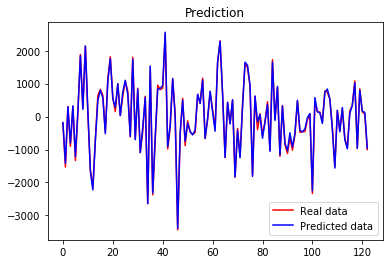

In [104]:
# Importing the dataset
# X = df[['res_1', 'res_2', 'res_3', 'res_4']].values
X = df[[
    'res_1',
    'res_2',
    'res_3',
    'res_4',
    'res_5',
    'res_6',
    'res_7',
    'res_8',
    'res_9',
    'res_10',
    'res_11',
    'res_12',
    'res_13',
    'res_14',
    'res_15',
    'res_16'
]].values
y = df.target.values

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# Initialising the ANN
model = Sequential()

# model.add(Dense(32, activation = 'relu', input_dim = 4))
# model.add(Dense(units = 32, activation = 'relu'))
# model.add(Dense(units = 32, activation = 'relu'))

model.add(Dense(12, input_dim=16, kernel_initializer='normal', activation='relu'))
# model.add(Dense(12, input_dim=4, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Adding the output layer

model.add(Dense(units = 1))

#model.add(Dense(1))
# Compiling the ANN
# model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the ANN to the Training set
model.fit(X_train, y_train, batch_size = 100, epochs = 1000)

y_pred = model.predict(X_test)

plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

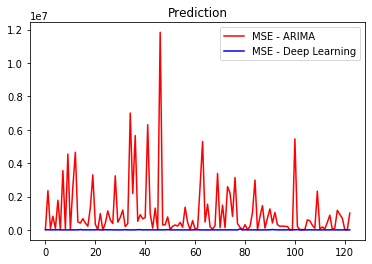

In [106]:
y_pred = model.predict(X_test)
mse_arima = y_test**2
mse_deep = (y_test - np.hstack(y_pred))**2
plt.plot(mse_arima, color = 'red', label = 'MSE - ARIMA')
plt.plot(mse_deep, color = 'blue', label = 'MSE - Deep Learning')
plt.title('Prediction')
plt.legend()
plt.show()

In [107]:
df_error = pd.DataFrame.from_dict({
    'arima': mse_arima,
    'dp': mse_deep
})

In [108]:
df_error.describe()

,arima,dp
count,1.230000e+02,123.000000
mean,1.077744e+06,4244.241503
std,1.724048e+06,6840.638498
min,1.802910e+03,0.653117
25%,1.256803e+05,399.984599
50%,4.165178e+05,1771.418274
75%,1.156478e+06,5168.465883
max,1.184196e+07,56885.893961


In [111]:
y_pred

array([[ -180.34087 ],
       [-1411.5662  ],
       [  298.13474 ],
       [ -801.30646 ],
       [  327.05203 ],
       [-1211.9879  ],
       [  167.22852 ],
       [ 1843.3499  ],
       [  220.62189 ],
       [ 2143.8652  ],
       [  167.24612 ],
       [-1643.8563  ],
       [-2225.9907  ],
       [ -730.0347  ],
       [  493.32162 ],
       [  801.4597  ],
       [  567.207   ],
       [ -521.572   ],
       [ 1078.4146  ],
       [ 1763.7617  ],
       [  541.8085  ],
       [  281.67984 ],
       [  997.1526  ],
       [   25.70923 ],
       [  747.00006 ],
       [ 1100.3206  ],
       [  670.37103 ],
       [ -599.02386 ],
       [ 1738.9185  ],
       [ -701.24634 ],
       [  829.1744  ],
       [-1095.2174  ],
       [ -332.09515 ],
       [  582.9813  ],
       [-2641.478   ],
       [ 1534.2837  ],
       [-2319.6008  ],
       [ -599.08887 ],
       [  834.8425  ],
       [  852.55975 ],
       [  950.32434 ],
       [ 2559.8875  ],
       [ -913.35034 ],
       [ -2

In [112]:
y_test

array([ -211.70928258, -1533.72005199,   297.32657856,  -903.72095881,
         300.91868589, -1333.78937719,   128.5857584 ,  1885.43807364,
         263.88021831,  2130.70042967,    83.31821466, -1609.78538341,
       -2157.6012468 ,  -696.46052229,   640.33935428,   821.61390123,
         645.38191147,  -471.1364078 ,  1147.90063056,  1816.16639999,
         579.51203751,   153.36648611,   991.33416464,    42.46069281,
         622.13821654,  1066.97802048,   772.58271563,  -618.22802563,
        1800.11870424,  -682.06408319,   860.88432376, -1092.33714764,
        -447.38131539,   617.48672249, -2646.16661182,  1476.52375627,
       -2377.20168686,  -719.86432348,   954.78593456,   816.376787  ,
         862.55610554,  2510.80360206,  -983.59138289,  -326.058108  ,
        1143.36725565,    73.91585009, -3441.21549309,  -545.76171238,
         554.55527738,  -883.11919226,  -128.2786416 ,  -466.46096971,
        -543.96132227,  -480.5469331 ,   668.92188247,   397.35585659,
      

In [113]:
# serialize model to JSON
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")

Saved model to disk


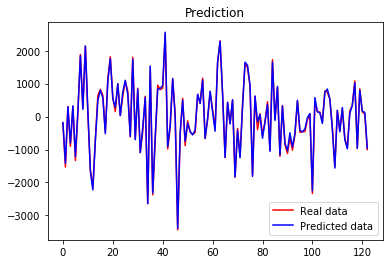

In [114]:
a = y_test
b = y_pred
plt.plot(a, color = 'red', label = 'Real data')
plt.plot(b, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()